# Gymnasium Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericmanley/S24-CS143AI/blob/main/gymnasium_demo.ipynb)

In 2016, Open AI released a package called Open AI Gym with a bunch of environments intended for use with implementing and comparing Reinforcement Learning Algorithms: https://openai.com/research/openai-gym-beta

It continues to be supported by an open source project called Gymnasium: https://gymnasium.farama.org/

We need to first install some packages

In [ ]:
import sys

!{sys.executable} -m pip install swig
!{sys.executable} -m pip install gymnasium[box2d]
!{sys.executable} -m pip install imageio==2.31.6

In [4]:
import gymnasium as gym
import numpy as np
import imageio
from IPython.display import Image, display

## Create an instance the environment

This will create an instance of the Lunard Lander task environment

In [5]:
#env = gym.make("LunarLander-v2", render_mode="human") #use this one if you're running locally instead of on colab
env = gym.make("LunarLander-v2")

## Making our first observation

We call `env.reset()` to re-start the environment at a beginning state.

This returns an `observation` - what the agent can *sense* from the environment with its sensors


In [6]:
observation, info = env.reset()
print(observation, info)

[ 0.00342722  1.3982698   0.34712702 -0.56224656 -0.00396451 -0.07862947
  0.          0.        ] {}


What does this mean? We have to look it up in the documentation here: https://gymnasium.farama.org/environments/box2d/lunar_lander/

Find the section on the *Observation Space* which describes what each of these numbers means. Make a note here to help you remember.

Note - there's no `info` getting returned.

So, if we wanted to save one of these values, like the **angle** on the lander, you could do it like this:

In [7]:
angle = observation[4]
print("The lander's angle is currently",angle)

The lander's angle is currently -0.003964514


## What actions can the agent make?

We could look up the possible actions by looking at `env.action_space`

In [8]:
print( env.action_space )

Discrete(4)


`Discrete(4)` means there are 4 discrete actions that can be taken by the agent, and they're numbered 0, 1, 2, and 3.

To figure out what these mean, you again have to look at the documentation: https://gymnasium.farama.org/environments/box2d/lunar_lander/ . Write notes here to remind yourself what they do.

You can generate a random action using the `sample()` method. Run this multiple times to notice it changes every time.

In [9]:
env.action_space.sample()

1

## Having the agent take an action

Use the `env.step()` method to take an action in the environment - you can pass in any one of the legal actions.

Let's take the 0 (do nothing) action and see what information we get back.



In [10]:
observation, reward, terminated, truncated, info = env.step(0)
print("observation:", observation)
print("reward:", reward)
print("terminated:", terminated)
print("truncated:", truncated)
print("info:",info)

observation: [ 0.00685453  1.3850429   0.34665835 -0.5878685  -0.00785014 -0.07771921
  0.          0.        ]
reward: -1.236768186282859
terminated: False
truncated: False
info: {}


notice that the observation is different - the lander is moving even when we do nothing!

Let's take a look at the other values
* `reward` - how good or bad your bot is doing. You can find out more about the rewards for this environment here: https://gymnasium.farama.org/environments/box2d/lunar_lander/
* `terminated` - the environment ended, the lander either landed or crashed. See more here: https://gymnasium.farama.org/content/basic_usage/#explaining-the-code
* `truncated` - another end state, but it means that the environment artificially ended after a certain number of steps

## Putting it all together

This code should run the environment for 1000 steps.

It makes only random moves.

It resets any time the environment ends.

In [11]:
env = gym.make("LunarLander-v2")

# first obsercation
observation, info = env.reset()

# loop 1000 times
for _ in range(1000):
    
    action = env.action_space.sample()  # select a random action
    observation, reward, terminated, truncated, info = env.step(action) # take the action, sense results
    
    # reset if the environment if it ended
    if terminated or truncated:
        observation, info = env.reset()

env.close()


## Visualizing what happened

If you are running locally *on your own computer*, the easiest way to see what happened is to create the environment like this, which will cause a window to pop up and display an animation as it runs.

**Warning:** This will freeze if you run it on Colab. If you are, just comment it out!

In [12]:
env = gym.make("LunarLander-v2",render_mode="human")

# first obsercation
observation, info = env.reset()

# loop 1000 times
for _ in range(1000):
    
    action = env.action_space.sample()  # select a random action
    observation, reward, terminated, truncated, info = env.step(action) # take the action, sense results
    
    # reset if the environment if it ended
    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Saving it as an animation GIF

We can also just save a RGB array representing each of the frames using `env.render()` and use the `imageio` module to save it as an animated image.

In [13]:
env = gym.make("LunarLander-v2",render_mode="rgb_array")

# first obsercation
observation, info = env.reset()

""" keep a list of all the rendered frames in the animation"""
frames = []

# loop 1000 times
for _ in range(1000):
    
    """ render the next frame, append to frames list """
    frames.append( env.render() ) 
    
    action = env.action_space.sample()  # select a random action
    observation, reward, terminated, truncated, info = env.step(action) # take the action, sense results
    
    # reset if the environment if it ended
    if terminated or truncated:
        observation, info = env.reset()

env.close()

""" save the animation as animation.gif and then display it in the notebook """
imageio.mimsave('animation.gif', frames, fps=30)  # fps: frames per second

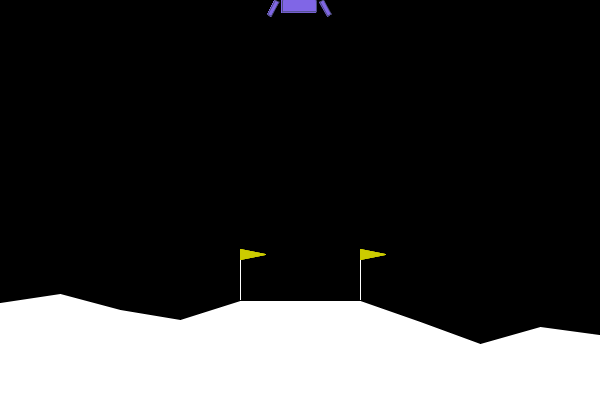

In [14]:
display(Image(filename='animation.gif'))

## Discussion

Discuss and write down ideas of how you could use the **reward** to help the agent make better decisions.

## Demo: A First Attempt at Reinforcement Learning

**Observation:** The reward function get worse if the lander is titled (https://gymnasium.farama.org/environments/box2d/lunar_lander/#rewards )

**Hypothesis:** The agent will be able to land better if it can avoid tilting.

**Reinforcement Learning Idea:** I'm going to start by doing the random actions and keep trach of the *rewards it gets for actions taken at each angle of tilt*

I'll keep track fo this info in a data structure that looks like this:

```
{
 0: 
    {
      0: [0.6275004397676014],
      3: [0.8467752038782816, -1.6131689575843768, -0.2988734234740764],
      1: [-2.3188639841060863, -2.2399322162422934],
      2: [2.997750325295198, -0.03495989783270942, 2.772519681512887, -100]
    },
 1: 
    {
      1: [-1.182677436498351, -2.310048732869119, -0.28300424190714923],
      2: [-2.0675012809866926, -0.7830802374510768, -3.715527282427291],
      3: [0.9168300833098908, 0.6896578840570851],
      0: [-1.8633792226584376, -1.8257791007253843, -0.7038620549938059]
    },
 -1: 
    {
      3: [-1.1995318117844522, -1.5579777550138079],
      2: [1.748523636642841, 3.1519073890257063, 1.9128228636768483],
      1: [-1.5447075393639966, -1.7315295660078778],
      0: [-1.5406157654919923]
    },
    # etc.
```
The 0, 1, -1 of the outer dictionary are angles (in degrees) - we'll do it for every possible angle

The 0, 3, 1, 2 are the different actions

The lists are the rewards we got for that action at that angle

Here's a function I can use to record in the angle, action, and reward into the `history` dictionary

In [15]:
def record_observation(history,angle,action,reward):
    if angle in history:
        if action in history[angle]:
            history[angle][action].append(reward)
        else:
            history[angle][action] = [reward]
    else:
        history[angle] = { action : [reward] }

Now let's run it - we'll do it a lot more times so we can hopefully see every possible angle

In [16]:
def radians_to_degrees(rads):
    return int(rads * 57.2958)

observation_history = {}

env = gym.make("LunarLander-v2")
observation, info = env.reset()

for _ in range(100000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    angle =  radians_to_degrees( observation[4] ) #save angle in degrees
    
    """ record the observation data in the observation_history dict  """
    record_observation(observation_history,angle,action,reward)
    
    if terminated or truncated:
        observation, info = env.reset()

env.close()

Here's an example of the history for angle 76

In [17]:
observation_history[76]

{2: [-5.312941771140674,
  -4.849926761808535,
  -5.67980672890103,
  -9.406938804178356,
  -7.358334305288838,
  -6.183451838462179,
  -8.770811167441583,
  -7.473350182393847,
  -4.434181767589098,
  -10.448512409962792,
  2.3803234793276262,
  -9.74601401618877,
  23.543306374600615,
  -9.712651930701657,
  -7.567667631650454,
  -5.478032322025956,
  -6.97924195313094,
  -5.240216139587505],
 3: [-1.7009517949947213,
  -1.7216239133901172,
  19.767462057514507,
  -1.5162005837040329,
  -2.3528605981925055,
  -2.1463351800079793,
  -2.3085110603468295,
  24.462220362613294,
  -2.0300882395525535,
  -0.6284724265657633,
  22.115398475333762,
  -2.0306907074435387,
  -100,
  -100,
  -2.088537765489973,
  -1.8686561027487005,
  -0.3406073420688631],
 1: [-3.0149959684085545,
  -3.047468348466593,
  -3.2876054388500777,
  -4.656789801370592,
  -100,
  -5.826828157535345,
  -5.949617215755636,
  4.464920020124368,
  -3.4182864096090086,
  -4.156720219606853,
  -6.035186497691682,
  -1.693

So now let's figure the best action on average for each angle:

In [18]:
best_actions = {}

for angle in observation_history:
    best_action = -1
    best_action_avg_reward = float("-inf")
    for action in observation_history[angle]:
        curr_action_avg_reward = sum(observation_history[angle][action])/len(observation_history[angle][action])
        if curr_action_avg_reward > best_action_avg_reward:
            best_action = action
            best_action_avg_reward = curr_action_avg_reward
    best_actions[angle] = best_action
            
best_actions

{0: 2,
 -1: 2,
 -2: 2,
 -3: 2,
 -4: 2,
 -5: 2,
 -6: 2,
 -7: 2,
 -8: 2,
 -9: 2,
 -10: 2,
 -11: 2,
 -12: 2,
 -13: 2,
 -14: 2,
 -15: 2,
 -16: 2,
 -17: 1,
 -18: 1,
 -19: 2,
 -20: 2,
 -21: 1,
 -22: 1,
 -23: 1,
 -24: 2,
 -25: 2,
 -26: 1,
 -27: 1,
 -28: 1,
 -29: 1,
 -30: 1,
 -31: 1,
 -32: 1,
 -33: 1,
 -34: 1,
 -35: 0,
 -36: 0,
 -37: 2,
 -38: 0,
 -39: 1,
 -40: 3,
 -41: 1,
 -42: 0,
 -43: 1,
 -44: 1,
 -45: 1,
 -46: 1,
 -47: 0,
 -48: 1,
 -49: 1,
 -50: 1,
 -51: 0,
 -52: 1,
 -53: 0,
 -54: 1,
 -55: 1,
 -56: 1,
 -57: 0,
 -58: 1,
 -59: 1,
 -60: 1,
 -61: 3,
 -62: 1,
 -63: 2,
 -64: 3,
 -65: 1,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 3,
 23: 2,
 24: 2,
 25: 2,
 26: 3,
 27: 3,
 28: 2,
 29: 2,
 31: 0,
 32: 0,
 33: 3,
 35: 3,
 36: 3,
 38: 0,
 57: 3,
 30: 2,
 34: 1,
 37: 0,
 39: 3,
 40: 3,
 41: 3,
 42: 3,
 43: 3,
 44: 3,
 45: 3,
 46: 3,
 47: 1,
 48: 3,
 49: 0,
 50: 3,
 52: 3,
 53: 3,
 5

In [19]:
env = gym.make("LunarLander-v2",render_mode="rgb_array")

# first obsercation
observation, info = env.reset()

frames = [] # keep a list of all the rendered frames in the animation

# loop 1000 times
for _ in range(1000):
    
    frames.append( env.render() ) # render the next frame, append to frames list
    
    """ the new way of choosing the action """
    action = best_actions[ radians_to_degrees(observation[4]) ]
    observation, reward, terminated, truncated, info = env.step(action) # take the action, sense results
    
    # reset if the environment if it ended
    if terminated or truncated:
        observation, info = env.reset()

env.close()

# save the animation as animation.gif and then display it in the notebook
imageio.mimsave('lunar_lander_learned.gif', frames, fps=30)  # fps: frames per second


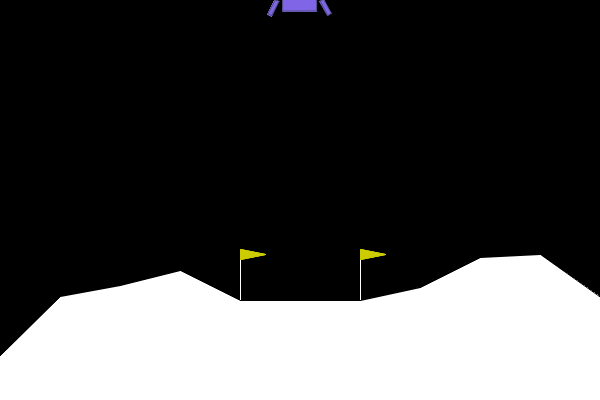

In [20]:
display(Image(filename='lunar_lander_learned.gif'))

## Discussion

The lander didn't crash! But why didn't it land?